In [6]:

from threeML import *


from polarpy import PolarLike, PolarResponse

%matplotlib notebook
import matplotlib.pyplot as plt

plt.style.use('mike')


# Creating POLAR spectral data

Once the POLAR data have been converted to an HDF5 format, they can be read with 3ML's TimeSeriesBuilder object.
As POLAR data are still tagged in UNIX time, a trigger time must be provided!


In [3]:
polar_trigger_time = 1484431269.5000


polar_spectral_ts = TimeSeriesBuilder.from_polar_spectrum(name='polar_spec',
                                               polar_hdf5_file='polar_data.h5',
                                               trigger_time=polar_trigger_time)


WARNING RuntimeWarning: Maximum MC energy (802.5) is smaller than maximum EBOUNDS energy (807.5)



<IPython.core.display.Javascript object>


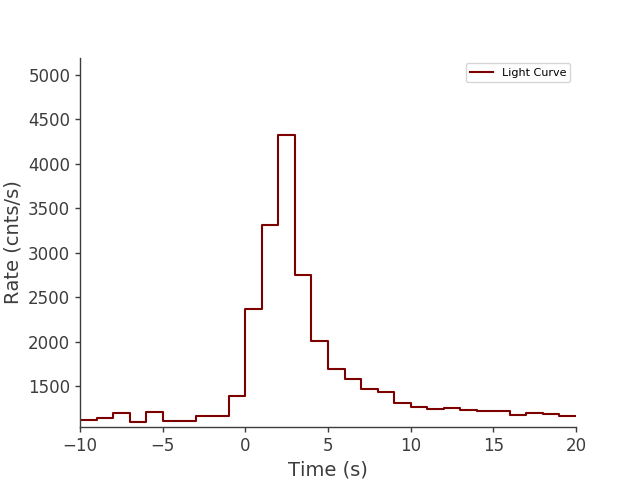

In [8]:
polar_spectral_ts.view_lightcurve();

## Background and source selection

The POLAR data are treated like any other 3ML time series and we refer you to those instructions for more details. However, we will quickly go over the process.

First, we fit a background

Auto-determined polynomial order: 1




Unbinned 1-order polynomial fit with the Nelder-Mead method




<IPython.core.display.Javascript object>


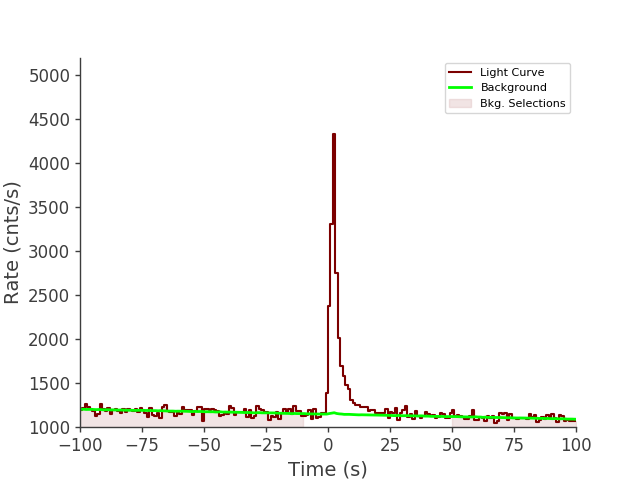

In [9]:
polar_spectral_ts.set_background_interval('-100--10','50-130')
#ts.set_active_time_interval('3-5')
polar_spectral_ts.view_lightcurve(-100,100);

With the background successfully fit, we can select a source region to analyze and even convert these selections to PHA file appropriate for XSPEC or any other dispersion basd fitting engine. 

<IPython.core.display.Javascript object>


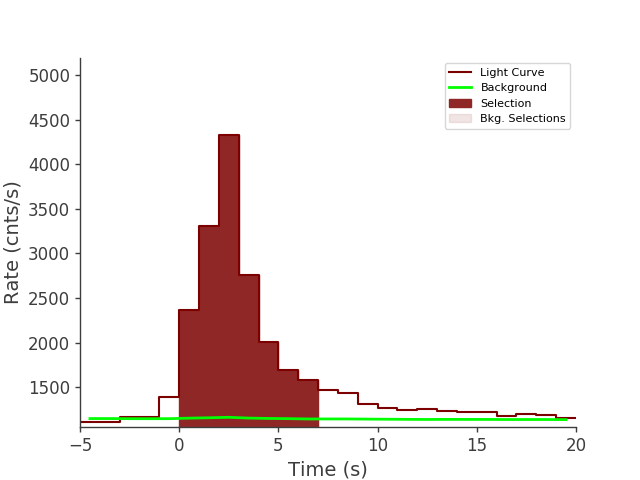

In [10]:
polar_spectral_ts.set_active_time_interval('0.-7.')
polar_spectral_ts.view_lightcurve(-5,20);

Now create a **SpectrumLike** plugin for analysis.

In [14]:
polar_speclike = polar_spectral_ts.to_spectrumlike()

# write PHA, BAK, and RSP
polar_speclike.write_pha('polar_pha', overwrite=True)

Auto-probed noise models:
- observation: poisson
- background: gaussian


<IPython.core.display.Javascript object>


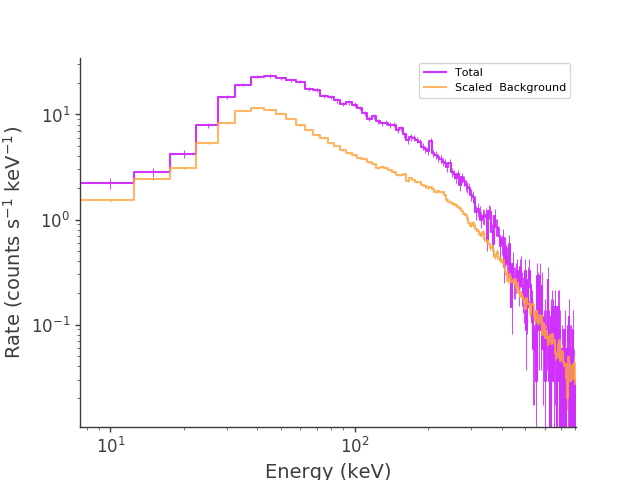

In [15]:
polar_speclike.view_count_spectrum();

# Creating POLAR polarization data

Now we demonstrate the polarization data extraction. As the data are also a time series, the process is the same.

In [17]:
polar_polarization_ts = TimeSeriesBuilder.from_polar_polarization(name='polar_pol',
                                               polar_hdf5_file='polar_data.h5',
                                               polar_hdf5_response='polar_rsp.h5',          
                                               trigger_time=polar_trigger_time)





WARNING RuntimeWarning: Maximum MC energy (802.5) is smaller than maximum EBOUNDS energy (807.5)



<IPython.core.display.Javascript object>


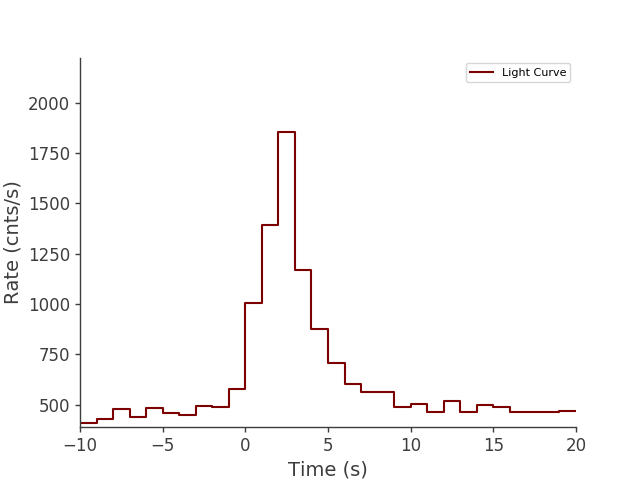

Auto-determined polynomial order: 1




Unbinned 1-order polynomial fit with the Nelder-Mead method




<IPython.core.display.Javascript object>


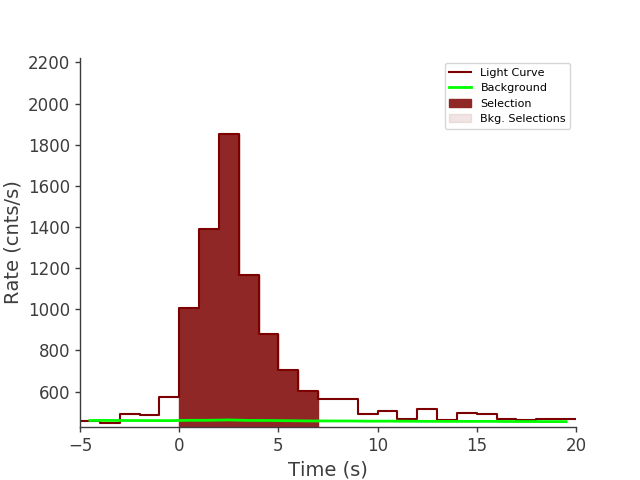

In [18]:
polar_polarization_ts.view_lightcurve();
polar_polarization_ts.set_background_interval('-100--10','50-130')
polar_polarization_ts.set_active_time_interval('0.-7.')
polar_polarization_ts.view_lightcurve(-5,20);



Now we can create a POLARLike plugin which is the plugin designed for the polarization analysis.

In [20]:
polar_data = polar_polarization_ts.to_polarlike()

<IPython.core.display.Javascript object>


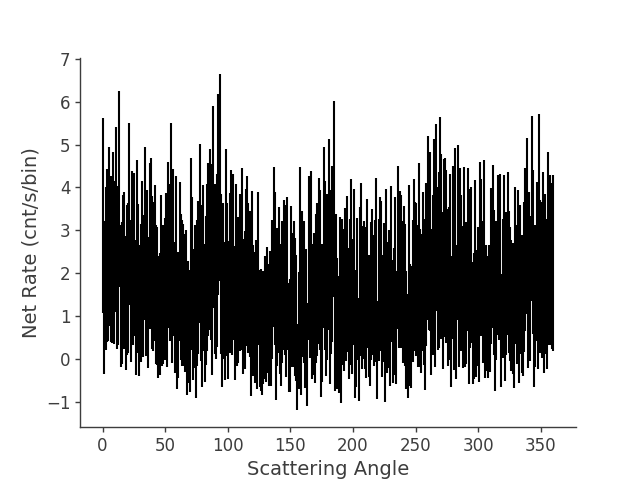

In [23]:
polar_data.display(show_model=False);

# Analysis

With our plugins created, we can now perform and analysis. We need to select a spectral model. 

In [35]:
band = Band()


lp = LinearPolarization(10,10)
sc =SpectralComponent('synch', band, lp)

ps = PointSource('polar_GRB',0,0,components=[sc])

model = Model(ps)


datalist = DataList(polar_data, polar_speclike)


model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (6):
--------------------

                                      value min_value max_value  \
polar_GRB.spectrum.synch.Band.K      0.0001      None      None   
polar_GRB.spectrum.synch.Band.alpha      -1      -1.5         3   
polar_GRB.spectrum.synch.Band.xp        500        10      None   
polar_GRB.spectrum.synch.Band.beta       -2        -5      -1.6   
polar_GRB...degree                       10         0       100   
polar_GRB...angle                        10         0       180   

                                               unit  
polar_GRB.spectrum.synch.Band.K      keV-1 s-1 cm-2  
polar_GRB.spectrum.synch.Band.alpha                  
polar_GRB.spectrum.synch.Band.xp                keV  
polar_GRB.spectrum.synch.Band.beta                   
polar_GRB...degree                                   
polar_GRB...angle                               deg  

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

In [36]:
jl = JointLikelihood(model, datalist)